<a href="https://colab.research.google.com/github/harvard-ml-courses/a-cs281-demo/blob/master/17_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -qU plotly torch daft opt-einsum networkx
!rm -fr start; git clone --single-branch -b demos2018 -q https://github.com/harvard-ml-courses/cs281-demos start; cp -f start/cs281.py cs281.py



In [0]:
import torch
import torch.distributions as ds
import daft

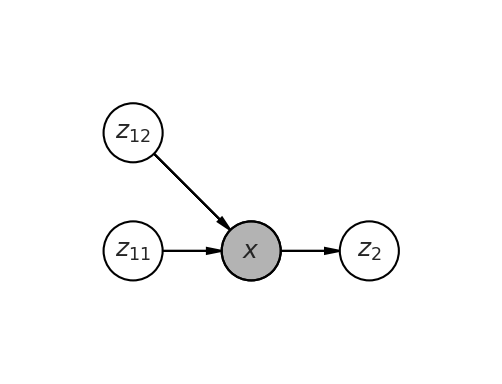

In [0]:
pgm = daft.PGM([4, 3])
pgm.add_node(daft.Node("z11", "$z_{11}$", 1, 1, observed=False))
pgm.add_node(daft.Node("z12", "$z_{12}$", 1, 2, observed=False))
pgm.add_node(daft.Node("x", "$x$", 2, 1, observed=True))
pgm.add_node(daft.Node("z2", "$z_2$", 3, 1, observed=False))

pgm.add_edge("z11", "x")
pgm.add_edge("z12", "x")
pgm.add_edge("x", "z2")

pgm.render()
pgm.figure.dpi=150

In [0]:
def cat(theta):
    return ds.Categorical(logits=theta)

def cat_s(theta, num_particles):
    return ds.Categorical(logits=theta).sample(torch.Size([num_particles]))
    

In [0]:
K = 3
theta_z_11 = torch.rand(K)
theta_z_12 =  torch.rand(K)
theta_x = torch.rand(K, K, K)
theta_z_2 = torch.rand(K, K)

    

In [0]:
def forward_sample(num_particles = 3):
    "or ancestral sampling"
    samples = torch.zeros([4, num_particles])
    z_11 = cat_s(theta_z_11, num_particles)
    z_12 = cat_s(theta_z_12, num_particles)
    x = cat_s(theta_x[z_11, z_12], 1)
    z_2 = cat_s(theta_z_2[x], 1)
    samples[0] = z_11
    samples[1] = z_12
    samples[2] = x
    samples[3] = z_2
    return samples

In [0]:
# Method 1: Monte-Carlo / Forward
monte_carlo = forward_sample(50)

In [0]:
# Method 2: Rejection sampling
rejection = monte_carlo[:, monte_carlo[2] == 2]

In [0]:
# Method 3: Importance sampling / Likelihood Weighting
def likelihood_weighting(X, num_particles = 3):
    samples = torch.zeros([4, num_particles])
    z_11 = cat_s(theta_z_11, num_particles)
    z_12 = cat_s(theta_z_12, num_particles)

    p_x = cat(theta_x[z_11, z_12])
    x = X
    w = p_x.log_prob(x).exp()
    
    z_2 = cat_s(theta_z_2[x], 1)
    samples[0] = z_11
    samples[1] = z_12
    samples[2] = x
    samples[3] = z_2
    return samples, w

In [0]:
samples, w = likelihood_weighting(torch.tensor([2]), 50)

In [0]:
print(samples.shape, w.shape)

torch.Size([4, 50]) torch.Size([50])
